In [1]:
# -*- coding: utf-8 -*-

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, add, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K

from sklearn.metrics import log_loss

from cnn_finetune.custom_layers.scale_layer import Scale

from cnn_finetune.load_cifar10 import load_cifar10_data

import sys
import os 

os.environ['CUDA_VISIBLE_DEVICES']='1'
sys.setrecursionlimit(3000)

Using TensorFlow backend.


In [2]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

#     x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a', bias=False)(input_tensor)
    x = Conv2D(nb_filter1, (1,1), name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
#     x = Convolution2D(nb_filter2, kernel_size, kernel_size,
#                       name=conv_name_base + '2b', bias=False)(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
               name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

#     x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

#     x = merge([x, input_tensor], mode='sum', name='res' + str(stage) + block)
    x = add([x, input_tensor], name='res'+str(stage)+block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

#     x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
#                       name=conv_name_base + '2a', bias=False)(input_tensor)
    x = Conv2D(nb_filter1, (1, 1), strides=strides,
               name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
#     x = Convolution2D(nb_filter2, kernel_size, kernel_size,
#                       name=conv_name_base + '2b', bias=False)(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
                      name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

#     x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

#     shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
#                              name=conv_name_base + '1', bias=False)(input_tensor)
    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                             name=conv_name_base + '1', use_bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)
    shortcut = Scale(axis=bn_axis, name=scale_name_base + '1')(shortcut)

#     x = merge([x, shortcut], mode='sum', name='res' + str(stage) + block)
    x = add([x, shortcut], name='res'+str(stage)+block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

In [3]:
def resnet101_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 101 Model for Keras

    Model Schema and layer naming follow that of the original Caffe implementation
    https://github.com/KaimingHe/deep-residual-networks

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/file/d/0Byy2AcGyEVxfdUV1MHJhelpnSG8/view?usp=sharing
    TensorFlow: https://drive.google.com/file/d/0Byy2AcGyEVxfTmRRVmpGWDczaXM/view?usp=sharing

    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
      bn_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      bn_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,4):
      x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,23):
      x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    model = Model(img_input, x_fc)

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = '/tf/cnn_finetune/imagenet_models/resnet101_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = '/tf/cnn_finetune/imagenet_models/resnet101_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
#     x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
#     x_newfc = Flatten()(x_newfc)
#     x_newfc = Dense(num_classes, activation='softmax', name='fc8')(x_newfc)

#     model = Model(img_input, x_newfc)

#     # Learning rate is changed to 0.001
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [4]:
# Example to fine-tune on 3000 samples from Cifar10

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = None 
batch_size = 16 
nb_epoch = 10

# Load Cifar10 data. Please implement your own load_data() module for your own dataset
#X_train, Y_train, X_valid, Y_valid = load_cifar10_data(img_rows, img_cols)

# Load our model
model = resnet101_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)



Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def get_image(filename):
    image = Image.open(filename)
    plt.imshow(image)
    plt.show()
    image1 = image.resize((224,224), Image.BILINEAR)
    image = np.array(image1)
    testimg = np.array([image])
    return testimg

def get_image_crop(filename):
    img = Image.open(filename)
    plt.imshow(img)
    plt.show()
    
    w, h = img.width, img.height
    if w>h:
        img_crop = img.crop((0, 0, h, h))
    else:
        img_crop = img.crop((0, 0, w, w))
        
    img_resize = img_crop.resize((224,224), Image.BILINEAR)
        
    plt.imshow(img_resize)
    plt.show()
        
    image = np.array(img_resize)
    testimg = np.array([image])
    return testimg

def predict_image(model, filename):
    image = get_image_crop(filename)
    predict = model.predict(image)
    print(predict.argmax(axis=1))
    return predict

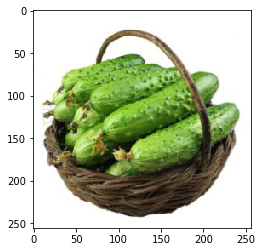

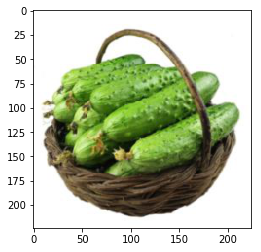

[928]


In [6]:
filename_raw = '/tf/Michael/preprocess/val/0005/fa0e785423400eedf92c792a0400ccfa.jpg'
ds = get_image_crop(filename_raw)
predict = model.predict(ds)
print(predict.argmax(axis=1))

In [7]:
def predict_image_by_class(image_class, file_type):
    filepath = os.path.join('/tf/Michael/preprocess', file_type, "%04d" % image_class)
    filenames = os.listdir(filepath)
    for filename in filenames:
        filename = os.path.join(filepath, filename)
        predict = predict_image(model, filename)

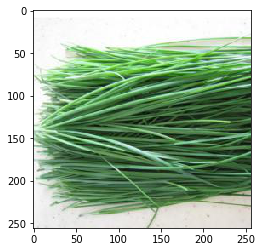

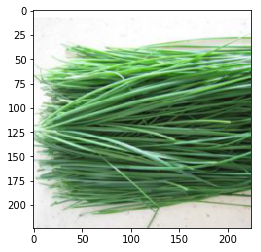

[462]


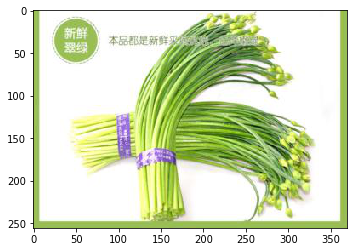

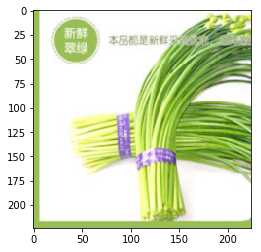

[646]


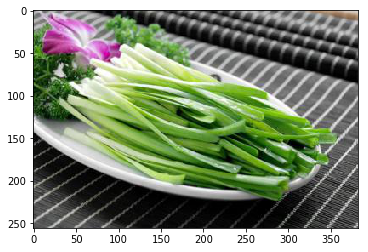

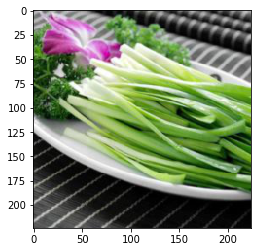

[818]


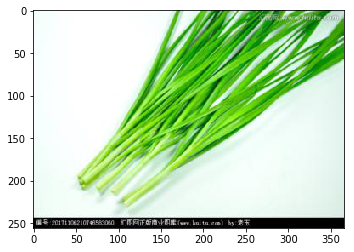

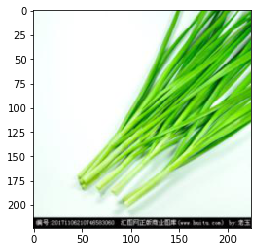

[462]


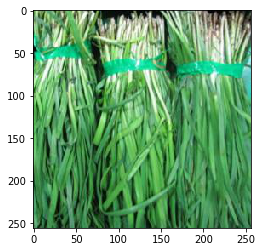

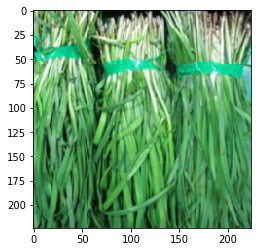

[135]


In [8]:
predict_image_by_class(0, 'val') 

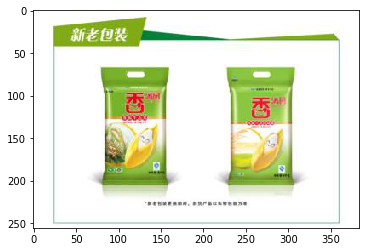

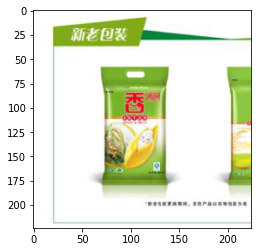

[916]


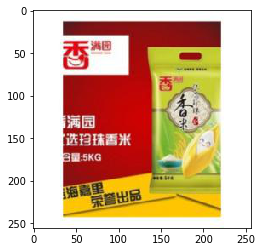

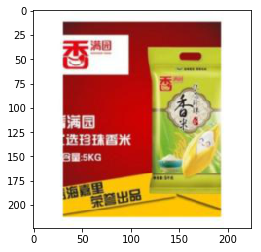

[916]


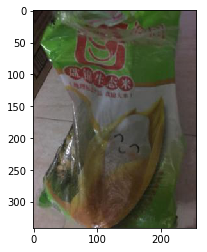

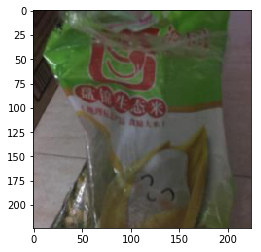

[728]


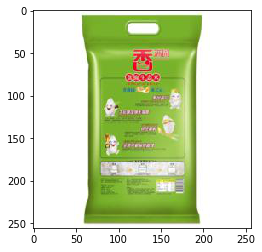

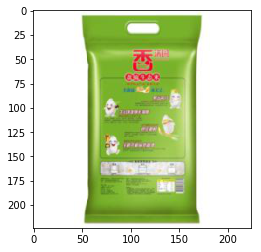

[916]


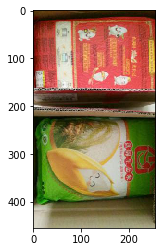

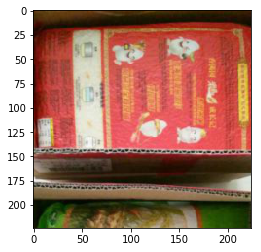

[664]


In [9]:
predict_image_by_class(15, 'val') 

cd862406ebfa51ab97c733042fa1d628.jpg


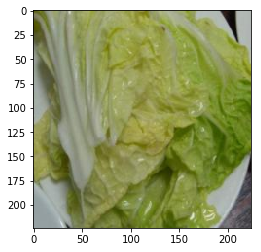

728
e1d567137212335a9a80927d9bccb245.jpg


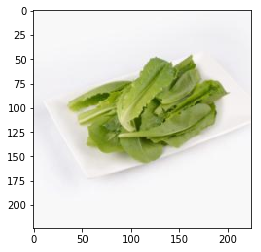

840
9e80433c77a71822e328b679a8a16436.jpg


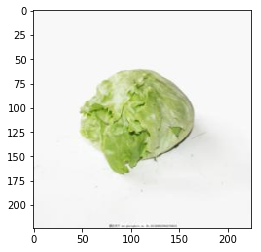

574
0027a1d788024b7e472a99aa3c453d21.jpg


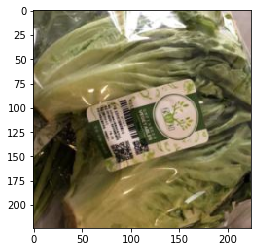

728
7430ffdcbf57d2b403d08a146aa3cfb0.jpg


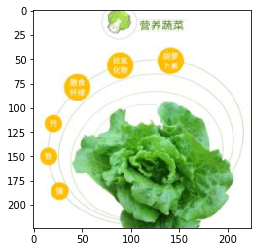

574


[728, 840, 574, 728, 574]

In [27]:
from ImageGenerator import ImageGenerator
Image_Generator = ImageGenerator()
class_id = 1
file_type = 'val'
images, ids = Image_Generator.get_images_by_class(class_id=class_id, ds=file_type, width=224 ,height=224)
predicts = model.predict(images)
for i in range(len(ids)):
    print(ids[i])
    plt.imshow(images[i])
    plt.show()
    print(predicts[i].argmax())
    
[i.argmax() for i in predicts]

#  生成val_resnet101.jon
##  json file
{ 
“0：  
	{  
		“id.jpg”：[949，descrip]  
	}  
}  

### load imagenet description file

In [16]:
import json
with open('/tf/imaterialist-product-2019/imagenet-category.json') as f:
    imagenet = json.load(f)

In [54]:
from ImageGenerator import ImageGenerator
Image_Generator = ImageGenerator()

class_id = 5
file_type = 'val'

result = {}
for class_id in range(2019):
    print(class_id)
    images, ids = Image_Generator.get_images_by_class(class_id=class_id, ds=file_type, width=224 ,height=224)
    predicts = model.predict(images)
    result[class_id] = {}
    for i in range(len(ids)):
        predict_num = predicts[i].argmax()
        result[class_id][ids[i]] = [int(predict_num), imagenet.get(str(predict_num))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [55]:
print(result[1])

{'cd862406ebfa51ab97c733042fa1d628.jpg': [728, 'plastic bag'], 'e1d567137212335a9a80927d9bccb245.jpg': [840, 'swab, swob, mop'], '0027a1d788024b7e472a99aa3c453d21.jpg': [728, 'plastic bag'], '9e80433c77a71822e328b679a8a16436.jpg': [574, 'golf ball'], '7430ffdcbf57d2b403d08a146aa3cfb0.jpg': [574, 'golf ball']}


In [57]:
filename = 'preprocess/%s_resnet101.json' % file_type
with open(filename, "w") as f:
    json.dump(result, f)

In [58]:
file_type = 'train'

result = {}
for class_id in range(2019):
    print(class_id)
    images, ids = Image_Generator.get_images_by_class(class_id=class_id, ds=file_type, width=224 ,height=224)
    predicts = model.predict(images)
    result[class_id] = {}
    for i in range(len(ids)):
        predict_num = predicts[i].argmax()
        result[class_id][ids[i]] = [int(predict_num), imagenet.get(str(predict_num))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [59]:
filename = 'preprocess/%s_resnet101.json' % file_type
with open(filename, "w") as f:
    json.dump(result, f)